# Project 4

 Student name: Zhiqiang Sun
 
 Student pace: self paced



## Business understanding
The medical dataset comes from Kermany et al. contains a set of x-ray images of pediatric patients. The images will show whether the patients have pneumonia or not. Our task is to build a model that can classify whether a given patient has pneumonia given a chest x-ray image. Since this is an Image Classification problem, we will solve it with Deep Learning.

## The Dataset
The dataset that we will use for image classification is the chese_xray which contains two categories: Pneumonia and Normal. The data was downloaded from https://data.mendeley.com/datasets/rscbjbr9sj/3 to the local drive and unzipped. The data set is assigned into two folders (train and test) and contains a subfolder for each Pneumonia and Normal category.
In each of the folders, there are a lot of x-ray images. To check how many samples were in each category, we used the OS.listdir methods.

In [40]:
import numpy as np
import os, shutil
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns


In [3]:
list_train_normal = os.listdir('chest_xray/train/normal')
list_train_PNEUMONIA = os.listdir('chest_xray/train/PNEUMONIA')
list_test_normal = os.listdir('chest_xray/test/normal')
list_test_PNEUMONIA = os.listdir('chest_xray/test/PNEUMONIA')


len(list_train_normal), len(list_train_PNEUMONIA), len(list_test_normal), len(list_test_PNEUMONIA)

(1349, 3884, 235, 390)

In the train folder, there is a regular folder that contains 1349 images and the PNEUMONIA folder, which includes 3884 images. The NORMAL folder in the test folder contains 235 pictures, and the PNEUMONIA folder contains 390 images. The images in each folder are too large for the modeling since our local computer is not very powerful for multiple testing. Therefore, we need to downsample the dataset to find the optimal model and parameter first. We are then using the entire dataset to train and test our model. Based on our earlier experience, we will use 20% of the total dataset to model our model. We also need to make 10% of the training data to the validation dataset.

## Plan

1. Downsampleing the data set by randomly choosing 20% of the initial training and testing images to the new data_org_subset folder. Make a new validation folder and randomly select 5% of the pictures from the training folder.
2. Define the trained generator, validation generator, and test generator.
3. Build the deep learning model base on the Pretrained CNN (VGG19) by adding a few fully connected layers. Then, train the model with selected images.
4. Retrain the model with complete training data. 
5. Evaluate the model with the test images.

### 1. Rebuild the data subset folder with 20% of the original images

In [5]:
# define the old and new direction of dataset

# define a new method to transfer the images between two folder
def transfer(no_of_files, source, dest):
    for i in range(no_of_files):
        #Variable random_file stores the name of the random file chosen
        random_file=np.random.choice(os.listdir(source))
        # print("%d} %s"%(i+1,random_file))
        source_file="%s/%s"%(source,random_file)
        dest_file=dest
        #"shutil.move" function moves file from one directory to another
        shutil.copy(source_file,dest_file)


# set the  propotion of images transfered to the new folders p_val, p_train, p_test and
# define a new method to creat and transfer images
def make_subset (old_dir, new_root_dir, p_val, p_train, p_test) :       

    # make the root dir folder
    os.mkdir(new_root_dir)

    # define the name of subset to save all the images in different categories        
    dir_names = ['train', 'val', 'test']
    cat_names = ['normal', 'PNEUMONIA']
    for d in dir_names:

        new_dir = os.path.join(new_root_dir, d)
        os.mkdir(new_dir)

        # make the source dir to train and test folder, since we donot have validation in the original folder, 
        # we make it to train folder 
        if d == 'val':
            source_dir = os.path.join(old_dir, 'train')
        else:
            source_dir = os.path.join(old_dir, d)


        for cat in cat_names:
            new_cat = os.path.join(new_dir, cat)
            source = os.path.join(source_dir, cat )
            os.mkdir(new_cat)
            no_of_files = len(os.listdir(source))
            # set the nunmber of copy to 20% from source folder. For the validation folder, copy 5% of the images of source
            if d == 'val':
                no_of_copy = int(p_val * no_of_files)
                
            if d == 'train':
                no_of_copy = int(p_train * no_of_files) 
                
            if d == 'test':
                no_of_copy = int(p_test * no_of_files )
                
            #print('d = ', d)    
            print('copy {} of files in {} total files  from {} to {}'.format(no_of_copy,no_of_files, source, new_cat)) 
            transfer(no_of_copy, source, new_cat)
        
old_dir = 'chest_xray/'
new_root_dir = 'data_org_subset/'
make_subset(old_dir, new_root_dir, p_val = 0.05, p_train = 0.2, p_test = 0.2)


copy 269 of files in 1349 total files  from chest_xray/train\normal to data_org_subset/train\normal
copy 776 of files in 3884 total files  from chest_xray/train\PNEUMONIA to data_org_subset/train\PNEUMONIA
copy 67 of files in 1349 total files  from chest_xray/train\normal to data_org_subset/val\normal
copy 194 of files in 3884 total files  from chest_xray/train\PNEUMONIA to data_org_subset/val\PNEUMONIA
copy 47 of files in 235 total files  from chest_xray/test\normal to data_org_subset/test\normal
copy 78 of files in 390 total files  from chest_xray/test\PNEUMONIA to data_org_subset/test\PNEUMONIA


We copied 20% of the training and testing images from the original folder. We also made a new folder for validation and randomly selected 5% of the images from the training folder.

## 2. Define the train generator, validation generator and test generator.

In [6]:

# define the direction for train , vlalidation and test folder

train_dir = '{}train'.format(new_root_dir)
validation_dir = '{}val/'.format(new_root_dir)
test_dir = '{}test/'.format(new_root_dir)

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')


train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(300, 300), 
                                                    batch_size= 20,
                                                    class_mode='categorical') 

# Get all the data in the directory split/validation (200 images), and reshape them
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(validation_dir, 
                                                                       target_size=(300, 300), 
                                                                       batch_size=20,
                                                                       class_mode='categorical')




Found 957 images belonging to 2 classes.
Found 255 images belonging to 2 classes.


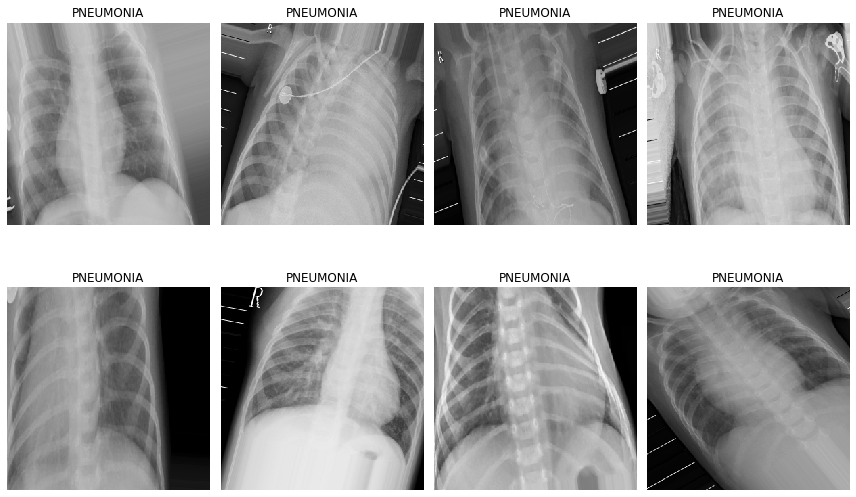

In [7]:
# plotsome of the train set images we resampled in the train dataset 
plt.figure(figsize=(12, 8))
for i in range(0, 8):
    plt.subplot(2, 4, i+1)
    for X_batch, Y_batch in train_generator:
        image = X_batch[0]        
        dic = {0:'NORMAL', 1:'PNEUMONIA'}
        plt.title(dic[Y_batch[0][0]])
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

We plot some of the images in the training dataset. However, I can not tell which one is a case of pneumonia and which one is a normal case just by looking at the pictures. So now we will train the computer with a Pretrainned CNN model to predict whether the picture belongs to pneumonia or normal case.

##  3. Build the model base on pretrain network VGG19.

In [27]:


# defined the pretrained model VGG19 and add more layer to the network.
cnn_base = VGG19(weights='imagenet', 
                 include_top=False, 
                 input_shape=(300, 300, 3))

# Define Model Architecture
model = models.Sequential()
model.add(cnn_base)
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

cnn_base.trainable = False

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 9, 9, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 41472)             0         
                                                                 
 dense (Dense)               (None, 64)                2654272   
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 256)               33024     
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 2)                 2

In [9]:
# Compilation
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=2e-5),
              metrics=['acc'])

# Fitting the Model
history = model.fit(train_generator,
                              steps_per_epoch=15,
                              epochs=10,
                              validation_data=val_generator,
                              validation_steps=8)


Epoch 1/10
15/15 [==============================] - 103s 7s/step - loss: 0.5447 - acc: 0.7533 - val_loss: 0.4575 - val_acc: 0.7812
Epoch 2/10
15/15 [==============================] - 100s 7s/step - loss: 0.4953 - acc: 0.7333 - val_loss: 0.4226 - val_acc: 0.7688
Epoch 3/10
15/15 [==============================] - 107s 7s/step - loss: 0.4545 - acc: 0.7533 - val_loss: 0.3840 - val_acc: 0.8813
Epoch 4/10
15/15 [==============================] - 108s 7s/step - loss: 0.4147 - acc: 0.7946 - val_loss: 0.3535 - val_acc: 0.8313
Epoch 5/10
15/15 [==============================] - 110s 7s/step - loss: 0.4017 - acc: 0.8047 - val_loss: 0.3721 - val_acc: 0.9312
Epoch 6/10
15/15 [==============================] - 112s 8s/step - loss: 0.3587 - acc: 0.8400 - val_loss: 0.3239 - val_acc: 0.9062
Epoch 7/10
15/15 [==============================] - 108s 7s/step - loss: 0.3368 - acc: 0.8451 - val_loss: 0.3544 - val_acc: 0.8813
Epoch 8/10
15/15 [==============================] - 109s 7s/step - loss: 0.2969 - a

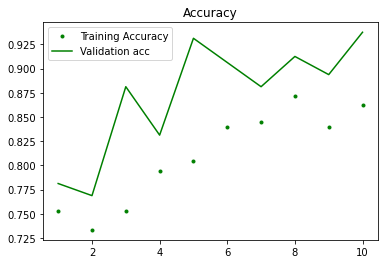

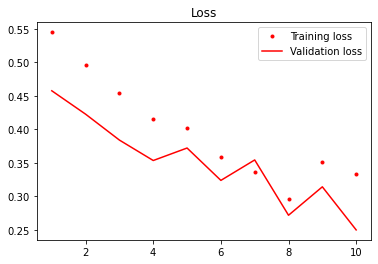

In [12]:
# Plot the accuracy and loss for train and validation. 
def plot_acc(history):
    train_acc = history.history['acc']
    val_acc = history.history['val_acc']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epch = range(1, len(train_acc) + 1)
    plt.plot(epch, train_acc, 'g.', label='Training Accuracy')
    plt.plot(epch, val_acc, 'g', label='Validation acc')
    plt.title('Accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epch, train_loss, 'r.', label='Training loss')
    plt.plot(epch, val_loss, 'r', label='Validation loss')
    plt.title('Loss')
    plt.legend()
    plt.show()

The acc and loss curve of training gave us a pretty good score, and the validation scores are going to a similar range in each step. Thus, we can use the same model for better training on the entire training dataset. 

In [13]:
#save model
model.save('results_on_partial_dataset.h5')

## 4. Retrain the model with full training data.

In [14]:
# remade the folder of train, val, test folder for full dataset. 
#Transfer 90% of train images to new train and 10% of train images to new validation folder. 
#Transfer 100% of test to new test folder
old_dir = 'chest_xray/'
new_root_dir = 'data_org_full/'
make_subset(old_dir, new_root_dir, p_val = 0.1, p_train = 0.9, p_test = 1)


copy 1214 of files in 1349 total files  from chest_xray/train\normal to data_org_full/train\normal
copy 3495 of files in 3884 total files  from chest_xray/train\PNEUMONIA to data_org_full/train\PNEUMONIA
copy 134 of files in 1349 total files  from chest_xray/train\normal to data_org_full/val\normal
copy 388 of files in 3884 total files  from chest_xray/train\PNEUMONIA to data_org_full/val\PNEUMONIA
copy 235 of files in 235 total files  from chest_xray/test\normal to data_org_full/test\normal
copy 390 of files in 390 total files  from chest_xray/test\PNEUMONIA to data_org_full/test\PNEUMONIA


In [42]:
train_dir = '{}train'.format(new_root_dir)
validation_dir = '{}val/'.format(new_root_dir)
test_dir = '{}test/'.format(new_root_dir)

full_train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')




full_train_generator = full_train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(300, 300), 
                                                    batch_size= 20,
                                                    class_mode='categorical') 

# Get all the data in the directory split/validation (, and reshape them
full_val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(validation_dir, 
                                                                       target_size=(300, 300), 
                                                                       batch_size=20,
                                                                       class_mode='categorical')



Found 3132 images belonging to 2 classes.
Found 492 images belonging to 2 classes.


In [43]:
# recompile the model and fit to the full training dataset.
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=2e-5),
              metrics=['acc'])

history = model.fit(full_train_generator,
                              steps_per_epoch=15,
                              epochs=20,
                              validation_data=full_val_generator,
                              validation_steps=10)

Epoch 1/20
15/15 [==============================] - 103s 7s/step - loss: 0.2719 - acc: 0.8870 - val_loss: 0.2330 - val_acc: 0.9100
Epoch 2/20
15/15 [==============================] - 106s 7s/step - loss: 0.2238 - acc: 0.9167 - val_loss: 0.2073 - val_acc: 0.9250
Epoch 3/20
15/15 [==============================] - 106s 7s/step - loss: 0.2244 - acc: 0.8900 - val_loss: 0.2235 - val_acc: 0.9050
Epoch 4/20
15/15 [==============================] - 106s 7s/step - loss: 0.2212 - acc: 0.9100 - val_loss: 0.2736 - val_acc: 0.8900
Epoch 5/20
15/15 [==============================] - 103s 7s/step - loss: 0.2360 - acc: 0.9007 - val_loss: 0.3543 - val_acc: 0.8200
Epoch 6/20
15/15 [==============================] - 105s 7s/step - loss: 0.2231 - acc: 0.9033 - val_loss: 0.2692 - val_acc: 0.8850
Epoch 7/20
15/15 [==============================] - 105s 7s/step - loss: 0.1796 - acc: 0.9300 - val_loss: 0.2150 - val_acc: 0.9250
Epoch 8/20
15/15 [==============================] - 104s 7s/step - loss: 0.1946 - a

In [50]:
#save model
model.save('results_on_full_dataset.h5')

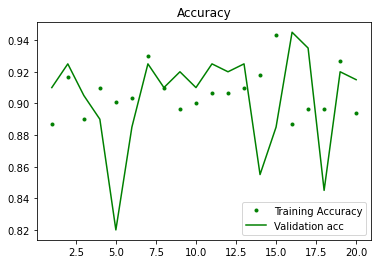

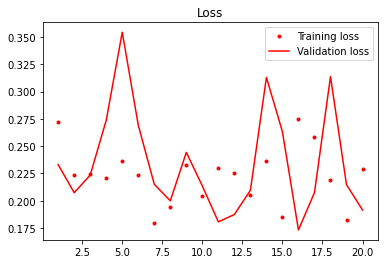

In [52]:
plot_acc(history)

In this fitting, both training accuracy and validation accuracy are very high. Even though the fluctuation of validation accuracy is bigger than training accuracy, both accuracies generally had the same trend. 

## 5. Evaluate the model with the test images.

In [ ]:
# Get all the data in the directory split/test (180 images), and reshape them


test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_dir, 
                                                                        target_size=(300, 300), 
                                                                        batch_size=399,
                                                                        class_mode='categorical',
                                                                        shuffle=False)


# generate the test_labels which is the y_true data
test_images, test_labels = next(test_generator)

Generate the test_labels for making the confusion box later. 

In [48]:
test_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
test_generator2 = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(300, 300),
                                                  batch_size=20,
                                                  class_mode='categorical',
                                                  shuffle=False)

test_loss, test_acc = model.evaluate(test_generator2, steps=10)

Found 399 images belonging to 2 classes.
10/10 [==============================] - 42s 4s/step - loss: 0.0685 - acc: 0.9750


The test accuracy of the model on test dataset are 95% which is very high also. 

In [12]:
# calculate the predicitons
preds  = model.predict(test_generator2, verbose = 1 )

20/20 [==============================] - 92s 5s/step


In [54]:

predictions = preds.copy()
predictions[predictions <= 0.6] = 0
predictions[predictions > 0.6] = 1

We calculate the predicitions of the classificaiton with our model.

<AxesSubplot:>

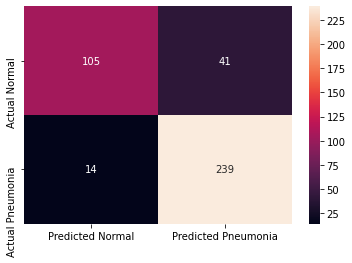

In [57]:
# calculate the confusion box for final model

cm = pd.DataFrame(data=confusion_matrix(test_labels[:,0], predictions[:,0], labels=[0,1]),index=["Actual Normal", "Actual Pneumonia"],
columns=["Predicted Normal", "Predicted Pneumonia"])
sns.heatmap(cm,annot=True,fmt="d")

In [58]:
# print the scores for normal and pneumonia categories
print(classification_report(y_true=test_labels[:,0],y_pred=predictions[:,0],target_names =['NORMAL', 'PNEUMONIA']))

              precision    recall  f1-score   support

      NORMAL       0.88      0.72      0.79       146
   PNEUMONIA       0.85      0.94      0.90       253

    accuracy                           0.86       399
   macro avg       0.87      0.83      0.84       399
weighted avg       0.86      0.86      0.86       399



The confusion box shows that the TP and TN predictions are much higher than the FN and FP results. The f1-score for both normal and pneumonia data are 0.79 and 0.9, which are very reasonable too. 

(399, 300, 300, 3)
(399, 2)


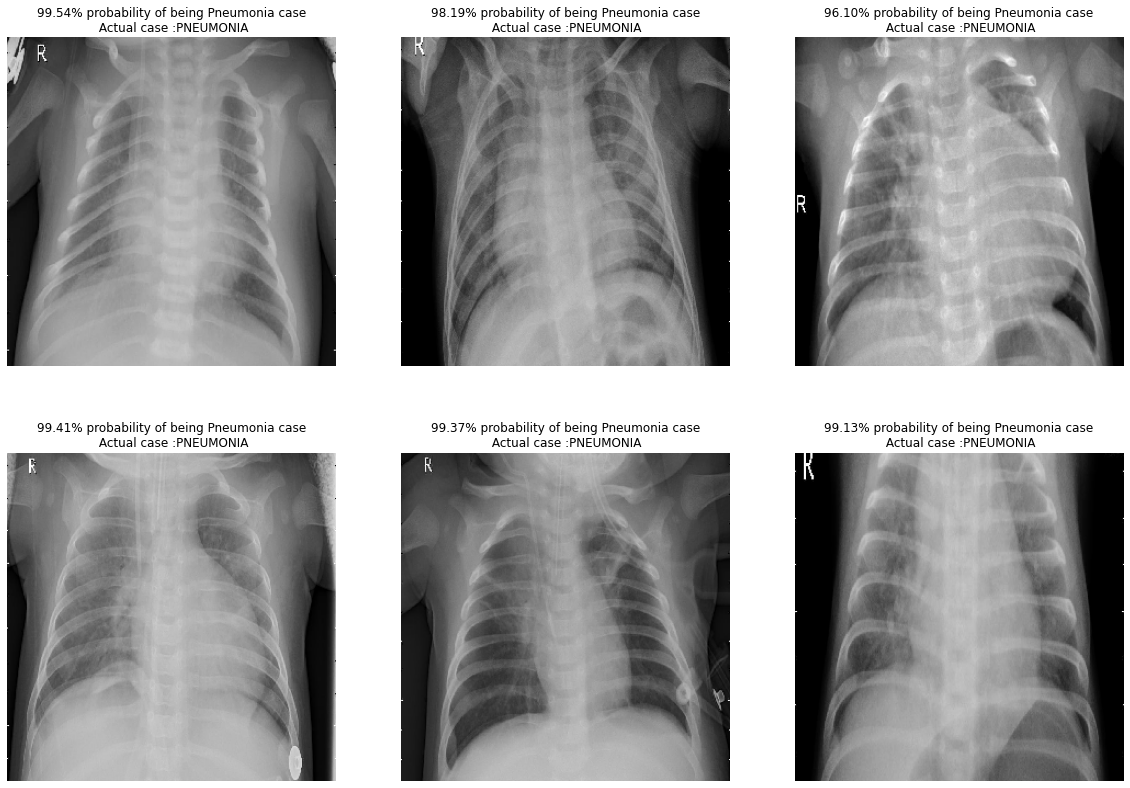

In [25]:
# print some of the predicted images with percentage of predictions
test_generator.reset()
x=np.concatenate([test_generator.next()[0] for i in range(test_generator.__len__())])
y=np.concatenate([test_generator.next()[1] for i in range(test_generator.__len__())])
print(x.shape)
print(y.shape)
dic = {0:'NORMAL', 1:'PNEUMONIA'}
plt.figure(figsize=(20,14))

#for i in range(0+200, 9+200):
for idx, i in enumerate(np.random.randint(1, 388, 6)):    
    plt.subplot(2, 3, idx+1)
    if preds[i, 0] >= 0.5: 
        out = ('{:.2%} probability of being Pneumonia case'.format(preds[i][0]))
      
      
    else: 
        out = ('{:.2%} probability of being Normal case'.format(1-preds[i][0]))
    plt.title(out +"\n Actual case :" + dic[y[i][0]])    
    plt.imshow(np.squeeze(x[i]))
    plt.axis('off')
plt.show()

We randomly plot some of the pictures from the test folder and give the prediction and actual case of the picture. The prediction and actual results are identical to each other in our samples. 

## Conclusion
Based on 20% of the whole dataset, we created a CNN model based on a Pretrained model (VGG19), which can classify X-ray images as Pneumonia cases or Normal cases. The model was then retrained with the whole dataset and tested with the separated test images. The accuracy of the prediction is around 95%. 